## Setup

In [1]:
pip uninstall dea_tools --yes

Found existing installation: dea-tools 0.1.dev1
Uninstalling dea-tools-0.1.dev1:
  Successfully uninstalled dea-tools-0.1.dev1
Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload
%autoreload 2

import datacube
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from datacube.utils.cog import write_cog
from datacube.utils.masking import mask_invalid_data
from datacube.utils.geometry import GeoBox, Geometry
from odc.algo import mask_cleanup

import sys
sys.path.insert(1, '../../Tools/')
from dea_tools.datahandling import mostcommon_crs
from dea_tools.bandindices import calculate_indices
from dea_tools.spatial import subpixel_contours, interpolate_2d, contours_to_arrays
from dea_tools.coastal import tidal_tag
from dea_tools.dask import create_local_dask_cluster

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

# Connect to datacube
dc = datacube.Datacube(app='Intertidal_elevation')

Client Scheduler: tcp://127.0.0.1:37435 Dashboard: /user/robbibt/proxy/8787/status,Cluster Workers: 1 Cores: 15 Memory: 125.85 GB


### Study area

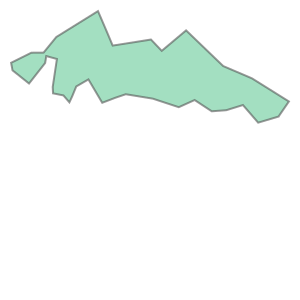

In [3]:
aoi = 'Wollogorang'
aoi = 'McCarthur River'
aoi = 'Greenbank'
# aoi = 'Seven Emu'
time_range = ('2017', '2021')
resolution = 10

# Import regions of interest
aoi_gdf = gpd.read_file('data/Phase_1_NT_Gov.geojson').set_index('Name').to_crs('EPSG:3577')
aoi_gdf.head()

# Select AOI
geom = Geometry(geom=aoi_gdf.loc[aoi].geometry, crs='EPSG:3577')
geom

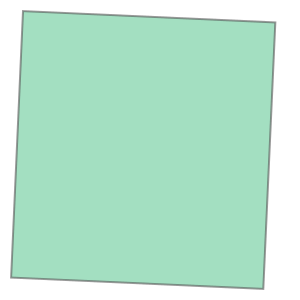

In [4]:
xmin, ymax = 136.69496195483225, -15.818692484010818
xmax, ymin = 136.73092570526103, -15.862001767243331

xmin, ymax = 137.74440730133688, -16.250688880149955


xmin, ymax = 137.70283024335083, -16.21825433795211
xmax, ymin = 137.76211426864734, -16.279337121561642

from shapely.geometry import box
geom = Geometry(geom=box(xmin, ymin, xmax, ymax),
                crs='EPSG:4326').to_crs('EPSG:3577')
geom


### Load data

In [ ]:
# Create the 'query' dictionary object
query_params = {
    'geopolygon': geom,
    'time': time_range}
    
load_params = {
    'group_by': 'solar_day',
    'resampling': {'*': 'average', 'fmask': 'nearest'},
    'dask_chunks': {'time': 1, 'x': 2048, 'y': 2048}
}

# Identify the most common projection system in the input query 
output_crs = mostcommon_crs(dc=dc, product='s2a_ard_granule', 
                            query=query_params)

In [ ]:
# Load Sentinel-2 data
s2_ds = dc.load(product=['s2a_ard_granule', 's2b_ard_granule'],
                measurements=['nbart_coastal_aerosol', 'nbart_blue', 'nbart_green', 'nbart_red', 'nbart_green', 'nbart_nir_1'],
                output_crs=output_crs,
                resolution=(-resolution, resolution),
                **query_params,
                **load_params).rename({'nbart_nir_1': 'nbart_nir'})

# Load Landsat-8 data
ls_ds = dc.load(product=['ga_ls8c_ard_3'],
                measurements=['nbart_coastal_aerosol', 'nbart_blue', 'nbart_green', 'nbart_red', 'nbart_green', 'nbart_nir'],
                time=query_params['time'],
                like=s2_ds.geobox,
                **load_params)   

# Combine into a single ds
ds = xr.concat([s2_ds, ls_ds], dim='time').sortby('time')

# Apply nodata masking
ds = mask_invalid_data(ds)

### Cloud masking

In [ ]:
# Set cloud mask band
cloud_bands = ds['nbart_coastal_aerosol']

# Compute median
aerosol_median = (cloud_bands.median(dim='time').chunk(
    ds.nbart_coastal_aerosol.isel(time=0).chunks))
# aerosol_median = ds.nbart_coastal_aerosol.rolling(time=50, center=True, min_periods=1).median()

# Calculate difference from median as ratio
ds['aerosol_diff'] = cloud_bands / aerosol_median

# Identify clouds (high diffs) or shadows (low diffs)
ds['cloud_mask'] = (ds['aerosol_diff'] > 1.8) | (ds['aerosol_diff'] < 0.35)

# CLean using morphology and add to dataset
ds['cloud_mask_clean'] = mask_cleanup(mask=ds['cloud_mask'],
                                      mask_filters=[('opening', 5),
                                                    ('dilation', 10)])


In [ ]:
# Identify poor quality scenes
to_keep = ~((ds['aerosol_diff'].std(dim=['x','y']) > 0.5) & 
            (ds['aerosol_diff'].mean(dim=['x','y']) > 2))

# Keep good scenes only and apply cloud mask
# ds_clear = ds.where(~ds.cloud_mask_clean)
ds_clear = ds.sel(time=to_keep).where(~ds.cloud_mask_clean)
ds_clear

In [ ]:
# ds[['nbart_red', 'nbart_green', 'nbart_blue', 'aerosol_diff', 'cloud_mask', 'cloud_mask_clean']].load()

In [ ]:
# for i in range(0, len(ds.time)):
    
#     fig, axes = plt.subplots(1, 4, figsize=(20, 5))

#     ds_i = ds.isel(time=i).drop('spatial_ref')
#     ds_i[['nbart_red', 'nbart_green', 'nbart_blue']].to_array().plot.imshow(vmin=50, vmax=3000, ax=axes[0])
#     ds_i['aerosol_diff'].plot.imshow(vmin=0, vmax=2, cmap='RdBu_r', ax=axes[1])
#     ds_i['cloud_mask'].plot.imshow(ax=axes[2], vmin=0, vmax=1)
#     ds_i['cloud_mask_clean'].plot.imshow(ax=axes[3], vmin=0, vmax=1)

#     for ax in axes:
#         ax.set_title('')

#     plt.suptitle('To keep' if to_keep.isel(time=i).item() else 'To drop');
#     fig.savefig(f'cloud_mask_test/{i}.jpg')

In [ ]:
# ds['cloud_mask'].mean(dim='time').plot.imshow()

In [ ]:
# ds['cloud_mask'].sel(time=to_keep).mean(dim='time').plot.imshow()

## Intertidal elevation

In [ ]:
# Calculate the water index
calculate_indices(ds_clear,
                  index='NDWI',
                  collection='ga_ls_3', 
                  drop=True,
                  inplace=True)


In [ ]:
# Calculate tides for each timestep in the satellite dataset
tidal_tag(ds=ds_clear, tidepost_lat=None, tidepost_lon=None)

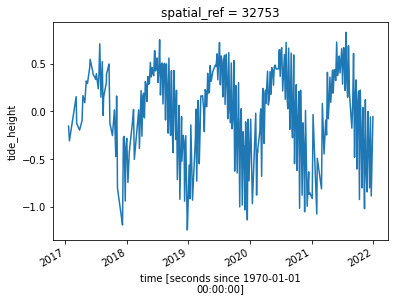

In [3]:
# Plot the resulting tide heights for each Landsat image:
ds_clear.tide_height.plot()

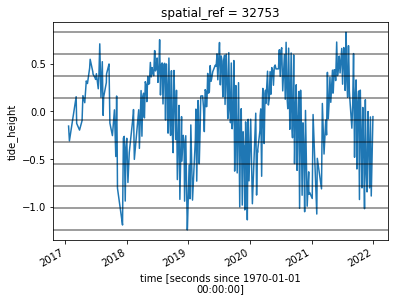

In [7]:
# classes
n = 9

# Sort every image by tide height
ds_clear = ds_clear.sortby('tide_height')

# Bin tide heights into 9 tidal intervals from low (1) to high tide (9)
binInterval = np.linspace(ds_clear.tide_height.min(),
                          ds_clear.tide_height.max(),
                          num=n+1)
tide_intervals = pd.cut(ds_clear.tide_height,
                        bins=binInterval,
                        labels=range(1, n+1),
                        include_lowest=True)

# Add interval to dataset
ds_clear['tide_interval'] = xr.DataArray(tide_intervals, coords=[ds_clear.time])
ds_clear.sortby('time').tide_height.plot()
for i in binInterval: plt.axhline(i, c='black', alpha=0.5)

In [ ]:
# For each interval, compute the median water index and tide height value
landsat_intervals = (ds_clear[['tide_interval', 'NDWI', 'tide_height']]
                     .groupby('tide_interval')
                     .median(dim='time')
                     .compute())

# Plot the resulting set of tidal intervals
item = ((landsat_intervals.NDWI < 0) * landsat_intervals.tide_interval).max(dim='tide_interval')
item.plot.imshow(cmap='RdYlBu_r')

In [ ]:
# Set up attributes to assign to each waterline
attribute_df = pd.DataFrame({'tide_m': landsat_intervals.tide_height.values})

# Extract waterlines
contours_gdf = subpixel_contours(da=item,
                                 z_values=[i - 0.5 for i in range(1, n)],
                                 crs=ds_clear.crs,
                                 affine=ds_clear.geobox.transform,
                                 attribute_df=attribute_df,
                                 min_vertices=2,  #20,
                                 output_path='tide_intervals.geojson',
                                 dim='tide_interval')
contours_gdf.explore(column='tide_m')

In [ ]:
# First convert our contours shapefile into an array of XYZ points
xyz_array = contours_to_arrays(contours_gdf, 'tide_m')

# Interpolate these XYZ points over the spatial extent of the Landsat dataset
intertidal_dem = interpolate_2d(ds=landsat_intervals,
                                x_coords=xyz_array[:, 0],
                                y_coords=xyz_array[:, 1],
                                z_coords=xyz_array[:, 2])

# Identify areas that are always wet (e.g. below low tide), or always dry
above_lowest = landsat_intervals.isel(tide_interval=0).NDWI < 0
below_highest = landsat_intervals.isel(tide_interval=-1).NDWI > 0

# Keep only pixels between high and low tide
intertidal_dem_clean = intertidal_dem.where(above_lowest & below_highest)

# Plot the cleaned dataset
intertidal_dem_clean.plot(cmap='viridis', size=8)
plt.show()

In [ ]:
# Export as a GeoTIFF
write_cog(geo_im=intertidal_dem_clean, 
          fname=f'intertidal_dem_{aoi}3.tif', 
          overwrite=True)

## Rolling experiments

In [ ]:
# ds_clear.NDWI.load()

In [5]:
import pickle
with open('ds_clear.pickle', 'rb') as handle:
    ds_clear = pickle.load(handle)

In [6]:
ds_clear

<xarray.Dataset>
Dimensions:      (time: 337, y: 685, x: 644)
Coordinates:
  * time         (time) datetime64[ns] 2017-01-21T00:53:13.103994 ... 2021-12...
  * y            (y) float64 8.205e+06 8.205e+06 ... 8.198e+06 8.198e+06
  * x            (x) float64 7.889e+05 7.889e+05 ... 7.953e+05 7.953e+05
    spatial_ref  int32 32753
Data variables:
    NDWI         (time, y, x) float64 0.897 0.897 0.897 ... 0.08621 0.2228
    tide_height  (time) float64 -0.155 -0.31 0.153 ... -0.371 -0.888 -0.056
Attributes:
    crs:           epsg:32753
    grid_mapping:  spatial_ref

In [ ]:
# Swap dimensions and sort by tide height
ds_tides = ds_clear.swap_dims({'time': 'tide_height'}).sortby('tide_height')          


In [ ]:
testing = ds_tides.rolling(tide_height=33, min_periods=15, center=True).median()

In [ ]:
# Extract waterlines
contours_gdf = subpixel_contours(da=testing.NDWI,
                                 z_values=[0],
                                 crs=ds_clear.crs,
                                 affine=ds_clear.geobox.transform,
                                 min_vertices=2,  
                                 output_path='test_rolling.geojson',
                                 dim='tide_height')

In [ ]:
contours_gdf.explore(column='tide_height', cmap='viridis')

In [ ]:
# First convert our contours shapefile into an array of XYZ points
xyz_array = contours_to_arrays(contours_gdf, 'tide_height')

# Interpolate these XYZ points over the spatial extent of the Landsat dataset
intertidal_dem = interpolate_2d(ds=ds_clear,
                                x_coords=xyz_array[:, 0],
                                y_coords=xyz_array[:, 1],
                                z_coords=xyz_array[:, 2],
                                method='rbf')

# Identify areas that are always wet (e.g. below low tide), or always dry
# above_lowest = landsat_intervals.isel(tide_interval=0).NDWI < 0
# below_highest = landsat_intervals.isel(tide_interval=-1).NDWI > 0

# Keep only pixels between high and low tide
# intertidal_dem_clean = intertidal_dem.where(above_lowest & below_highest)

In [ ]:
intertidal_dem.isel(x=slice(0, 150), y=slice(60, 130)).plot()

In [ ]:
import numpy
import scipy.interpolate

data = numpy.random.randint(0, 10, size=(10, 10))

# Create the knots (10 knots in each direction, making 100 total
xcoord = numpy.linspace(5, data.shape[0]-5, 10)
ycoord = numpy.linspace(5, data.shape[1]-5, 10)

# Create all weights, and set them to 0 when the data is NaN
weights = numpy.ones(data.shape)
weights[numpy.isnan(data)] = 1e-15  # weights must be >0

# LSQBivariateSpline needs x and y coordinates as 1-D arrays
x, y = numpy.indices(data.shape)
spline_fit = scipy.interpolate.LSQBivariateSpline(x.ravel(), y.ravel(), data.ravel(), 
                                               xcoord, ycoord, 
                                               w=weights.ravel(),
                                               bbox=[None, None, None, None], 
                                               kx=2, ky=2)

In [ ]:
import numpy as np
from scipy.interpolate import RectBivariateSpline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Regularly-spaced, coarse grid
dx, dy = 0.4, 0.4
xmax, ymax = 2, 4
x = np.arange(-xmax, xmax, dx)
y = np.arange(-ymax, ymax, dy)
X, Y = np.meshgrid(x, y)
Z = np.exp(-(2*X)**2 - (Y/2)**2)

interp_spline = RectBivariateSpline(y, x, Z)

# Regularly-spaced, fine grid
dx2, dy2 = 0.16, 0.16
x2 = np.arange(-xmax, xmax, dx2)
y2 = np.arange(-ymax, ymax, dy2)
X2, Y2 = np.meshgrid(x2,y2)
Z2 = interp_spline(y2, x2)

fig, ax = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection': '3d'})
ax[0].plot_wireframe(X, Y, Z, color='k')

ax[1].plot_wireframe(X2, Y2, Z2, color='k')
for axes in ax:
    axes.set_zlim(-0.2,1)
    axes.set_axis_off()

fig.tight_layout()
plt.show()

In [ ]:
plt.imshow(Z)

In [ ]:
import matplotlib.pyplot as plt
from scipy.interpolate import RBFInterpolator
from scipy.stats.qmc import Halton
rng = np.random.default_rng()
xobs = 2*Halton(2, seed=rng).random(100) - 1
yobs = np.sum(xobs, axis=1)*np.exp(-6*np.sum(xobs**2, axis=1))
xgrid = np.mgrid[-1:1:50j, -1:1:50j]
xflat = xgrid.reshape(2, -1).T
yflat = RBFInterpolator(xobs, yobs)(xflat)
ygrid = yflat.reshape(50, 50)
fig, ax = plt.subplots()
ax.pcolormesh(*xgrid, ygrid, vmin=-0.25, vmax=0.25, shading='gouraud')
p = ax.scatter(*xobs.T, c=yobs, s=50, ec='k', vmin=-0.25, vmax=0.25)
fig.colorbar(p)
plt.show()

In [ ]:
interpolate_2d

In [92]:
shoreline_dict = {}

for n in [3, 6, 12]:

#     # classes
#     n = 3

    # Sort every image by tide height
    ds_clear = ds_clear.sortby('tide_height')

    # Bin tide heights into 9 tidal intervals from low (1) to high tide (9)
    binInterval = np.linspace(ds_clear.tide_height.min(),
                              ds_clear.tide_height.max(),
                              num=n+1)
    tide_intervals = pd.cut(ds_clear.tide_height,
                            bins=binInterval,
                            labels=range(1, n+1),
                            include_lowest=True)

    # Add interval to dataset
    ds_clear['tide_interval'] = xr.DataArray(tide_intervals, coords=[ds_clear.time])
#     ds_clear.sortby('time').tide_height.plot()
#     for i in binInterval: plt.axhline(i, c='black', alpha=0.5)

    # For each interval, compute the median water index and tide height value
    landsat_intervals = (ds_clear[['tide_interval', 'NDWI', 'tide_height']]
                         .groupby('tide_interval')
                         .median(dim='time')
                         .compute()
                        )

    # Set up attributes to assign to each waterline
    attribute_df = pd.DataFrame({'tide_m': landsat_intervals.tide_height.values})

    # Extract waterlines
    contours_gdf = subpixel_contours(da=landsat_intervals.NDWI,
                                     z_values=[0],
                                     crs=ds_clear.crs,
                                     affine=ds_clear.geobox.transform,
                                     attribute_df=attribute_df,
                                     min_vertices=2,  #20,
                                     output_path='tide_intervals.geojson',
                                     dim='tide_interval')
    
    shoreline_dict[n] = contours_gdf
#     contours_gdf.explore(column='tide_m')

In [27]:
# shoreline_dict[3].to_crs('EPSG:4326').to_file('test_3.geojson')

In [28]:
# shoreline_dict[6].to_crs('EPSG:4326').to_file('test_6.geojson')

In [29]:
# shoreline_dict[12].to_crs('EPSG:4326').to_file('test_12.geojson')

In [75]:
# shoreline_dict[6].explode().reset_index().intersects(shoreline_dict[3].unary_union)

In [25]:
# import geopandas as gpd

In [34]:
# line = shoreline_dict[6].iloc[0].geometry

In [198]:
from shapely.geometry import LineString, MultiPoint
from shapely.ops import split
from shapely.geometry import MultiLineString

from shapely.ops import split,snap
def split_line_by_point(line, point, tolerance: float=1.0e-8):
    return split(snap(line, point, tolerance), point)

# result = split_line_by_point(line,points)


def test(line, val):
    splitter = MultiPoint([line.interpolate(i) for i in range(0, int(line.length), 100)])
#     print(len(splitter))
    out = split_line_by_point(line, splitter)

    return gpd.GeoDataFrame(data={'tide_m': [val]*len(out)}, geometry=[i for i in out], crs='EPSG:32753')

In [197]:
lines_6 = shoreline_dict[6]

lines_6 = pd.concat([test(i.geometry, i.tide_m) for (x, i) in lines_6.iterrows()])
# testing.to_crs('EPSG:4326').to_file('test_6_broken.geojson')

# lines_6['geometry'] = lines_6.apply(lambda line: test(line.geometry), axis=1)
# lines_6 = lines_6.explode().reset_index(drop=True)

/tmp/ipykernel_133/3823154924.py:17: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  print(len(out))
/tmp/ipykernel_133/3823154924.py:19: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  return gpd.GeoDataFrame(data={'tide_m': [val]*len(out)}, geometry=[i for i in out], crs='EPSG:32753')
/tmp/ipykernel_133/3823154924.py:19: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return gpd.GeoDataFrame(data={'tide_m': [val]*len(out)}, geometry=[i for i in out], crs='EPSG:32753')


611


/tmp/ipykernel_133/3823154924.py:17: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  print(len(out))
/tmp/ipykernel_133/3823154924.py:19: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  return gpd.GeoDataFrame(data={'tide_m': [val]*len(out)}, geometry=[i for i in out], crs='EPSG:32753')
/tmp/ipykernel_133/3823154924.py:19: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return gpd.GeoDataFrame(data={'tide_m': [val]*len(out)}, geometry=[i for i in out], crs='EPSG:32753')


461


/tmp/ipykernel_133/3823154924.py:17: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  print(len(out))
/tmp/ipykernel_133/3823154924.py:19: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  return gpd.GeoDataFrame(data={'tide_m': [val]*len(out)}, geometry=[i for i in out], crs='EPSG:32753')
/tmp/ipykernel_133/3823154924.py:19: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return gpd.GeoDataFrame(data={'tide_m': [val]*len(out)}, geometry=[i for i in out], crs='EPSG:32753')


284


/tmp/ipykernel_133/3823154924.py:17: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  print(len(out))
/tmp/ipykernel_133/3823154924.py:19: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  return gpd.GeoDataFrame(data={'tide_m': [val]*len(out)}, geometry=[i for i in out], crs='EPSG:32753')
/tmp/ipykernel_133/3823154924.py:19: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return gpd.GeoDataFrame(data={'tide_m': [val]*len(out)}, geometry=[i for i in out], crs='EPSG:32753')


211


/tmp/ipykernel_133/3823154924.py:17: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  print(len(out))
/tmp/ipykernel_133/3823154924.py:19: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  return gpd.GeoDataFrame(data={'tide_m': [val]*len(out)}, geometry=[i for i in out], crs='EPSG:32753')
/tmp/ipykernel_133/3823154924.py:19: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return gpd.GeoDataFrame(data={'tide_m': [val]*len(out)}, geometry=[i for i in out], crs='EPSG:32753')


212
226


/tmp/ipykernel_133/3823154924.py:17: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  print(len(out))
/tmp/ipykernel_133/3823154924.py:19: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  return gpd.GeoDataFrame(data={'tide_m': [val]*len(out)}, geometry=[i for i in out], crs='EPSG:32753')
/tmp/ipykernel_133/3823154924.py:19: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return gpd.GeoDataFrame(data={'tide_m': [val]*len(out)}, geometry=[i for i in out], crs='EPSG:32753')


In [166]:
lines_6

<generator object DataFrame.iterrows at 0x7fbef0d915f0>

In [161]:
lines_6.apply(lambda line: test(line.geometry, line.tide_m), axis=1).shape

/tmp/ipykernel_133/2645657613.py:13: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  return gpd.GeoDataFrame(data=[val]*len(out), geometry=[i for i in out])
/tmp/ipykernel_133/2645657613.py:13: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return gpd.GeoDataFrame(data=[val]*len(out), geometry=[i for i in out])
/tmp/ipykernel_133/2645657613.py:13: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  return gpd.GeoDataFrame(data=[val]*len(out), geometry=[i for i in out])
/tmp/ipykernel_133/2645657613.py:13: Shape

(6,)

In [147]:
out = lines_6.apply(lambda line: test(line.geometry, line.tide_m), axis=1)
len(out.iloc[[0]].explode(ignore_index=False))

/env/lib/python3.8/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/env/lib/python3.8/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/env/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values
/env/lib/python3.8/site-packages/pandas/core/series.py:4032: Shap

133

/tmp/ipykernel_133/1535953391.py:1: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(out.iloc[0])


133

In [87]:
lines_6.to_crs('EPSG:4326').to_file('test_6_broken.geojson')

In [199]:
lines_6.loc[~lines_6.intersects(shoreline_dict[3].unary_union)].to_crs('EPSG:4326').to_file('test_6_nointersect.geojson')

<AxesSubplot:>

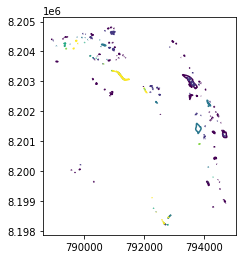

In [85]:
lines_6.loc[~lines_6.intersects(shoreline_dict[3].unary_union)].plot(column='tide_m')